In [28]:
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

from helpers import calculate_mse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and prepare data

#### Load the Data
`ratings` is a sparse matrix in the shape of (num_items, num_users)

In [29]:
from helpers import load_data, preprocess_data

DATA_PATH = '../data/'
PREDICTION_PATH = '../data/predictions/'
ratings = load_data('{dp}data_train.csv'.format(dp=DATA_PATH))
#ratings = load_data('{dp}movielens100k.csv'.format(dp=DATA_PATH))

number of items: 10000, number of users: 1000


#### Plot the number of ratings per movie and user

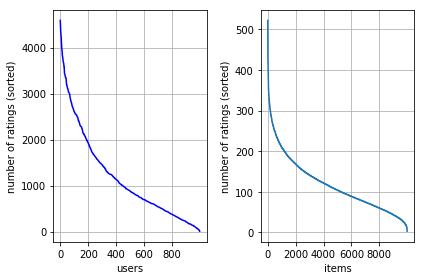

min # of items per user = 8, min # of users per item = 3.


In [30]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

#### Split the data into a train and test set

In [31]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][:, valid_users]
    
    # LIL is a convenient format for constructing sparse matrices
    train = sp.lil_matrix(valid_ratings.shape)
    test = sp.lil_matrix(valid_ratings.shape)
    
    valid_ratings_i, valid_ratings_u, valid_ratings_v = sp.find(valid_ratings)
    valid_ratings_p_idx = np.random.permutation(range(len(valid_ratings_i)))
    
    n_test = int(p_test*len(valid_ratings_i))
    
    for idx in valid_ratings_p_idx[:n_test]:
        test[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]
        
    for idx in valid_ratings_p_idx[n_test:]:
        train[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]

    print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    
    # convert to CSR for faster operations
    return valid_ratings, train.tocsr(), test.tocsr()

In [32]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)

Total number of nonzero elements in original data:1176952
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


# Auxiliary functions

In [33]:
def compute_division(a, b):
    """Computes element by element division.
    If x/0 returns 0.
    """
    # Raises error if vectors have different lengths
    assert(len(a) == len(b))
    
    # Computes division
    res = a.copy()
    for i in range(len(a)):
        if b[i] == 0:
            res[i] = 0
        else:
            res[i] = a[i] / b[i]

    return res

# Baselines 

#### Ex10 functions

Test implementations:

#### Project functions

In [34]:
# Baseline rating
def baseline_rating(data):
    """Implements baseline method using the global mean."""
    # Compute global mean using training data
    data_mean = data.sum() / data.count_nonzero()
    return data_mean


# User or item specific effect
def baseline_user_item_specific(data, mean):
    """Implements baseline method using either the user
    or the item mean, as indicated in parameter mean."""
    if mean=="user":
        flag = 1
        inv_flag = 0
    else:
        flag = 0
        inv_flag = 1

    num = data.shape[flag]
    
    # Obtain data_deviations, which are the ratings minus global avg
    global_mean = baseline_rating(data)
    data_deviations = data.copy()
    data_deviations.data -= global_mean
    
    # Compute means using training data
    # get rows, columns and values for elements in data_deviations
    data_rcv = sp.find(data_deviations)
    counts = np.bincount(data_rcv[flag], minlength=num)
    sums = np.bincount(data_rcv[flag], weights=data_rcv[2], minlength=num)
    means = compute_division(sums, counts)

    return means

#### Predict using global mean

#### Predict using global, user and item means (baseline)

We first estimate the RMSE for our test set:

In [35]:
def train_model_baseline(data, test_data, test_flag, sub_flag=False, sub_filename="new_submission"):
    """
    If 'test_flag' is True, then 'data' should be the training dataset
    'test_data' the test dataset. In this case sub_flag is ignored.
    
    If 'test_flag' is False and 'sub_flag' is True, then 'data' should be
    the entire ratings dataset and 'test_data' should be a sample submission.
    
    Both 'data' and 'test_data' should be csr sparse matrices.
    """
    assert test_flag or sub_flag, "Specify a task"
    
    global_mean = baseline_rating(data)
    user_means = baseline_user_item_specific(data, 'user')
    item_means = baseline_user_item_specific(data, 'item')

    # Do predictions
    num_items, num_users = test_data.shape
    test_rcv = sp.find(test_data)
    pred_test = test_rcv[2].copy()
    pred_test = 1.0 * pred_test
    for i in range(num_items):
        for u in range(num_users):
            pred_i_u = global_mean + user_means[u] + item_means[i]
            pred_test[(test_rcv[0]==i) & (test_rcv[1]==u)] = pred_i_u
    
    if test_flag:
        # Compute and print test error
        test_mse = calculate_mse(test_rcv[2], pred_test)
        test_rmse = np.sqrt(test_mse / len(test_rcv[2]))
        print("Test RMSE of baseline using baseline: {e}".format(e=test_rmse))

    elif sub_flag:
        create_csv_submission_spmat(pred_test, sub_filename)
    
    return pred_test

In [36]:
pred_test = train_model_baseline(train, test, True)

Test RMSE of baseline using baseline: 1.0057078177840961


Now we prepare the submission file training on all data:

In [39]:
def create_csv_submission_spmat(prediction, name):
    """Creates an output file in csv format for submission to kaggle
    Arguments: prediction (predicted rating, as a csr sparse matrix)
               name (string name of .csv output file to be created)
    """
    with open('{dp}{fn}.csv'.format(dp=PREDICTION_PATH, fn=name), 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r, c, v in sp.find(pred_test):
            writer.writerow({'Id':'r{r}_c{c}'.format(r=r,c=c),'Prediction':v})

In [ ]:
ratings_csr = ratings.tocsr()
sample_submission = load_data('{dp}sample_submission.csv'.format(dp=DATA_PATH))
sample_submission_csr = sample_submission.tocsr()

train_model_baseline(ratings_csr, sample_submission_csr, False, True, "baselines")

number of items: 10000, number of users: 1000


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [ ]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [ ]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    raise NotImplementedError

In [ ]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO
        # do matrix factorization.
        # ***************************************************
        raise NotImplementedError

        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    raise NotImplementedError

matrix_factorization_SGD(train, test)   

### Learn the Matrix Factorization using Alternating Least Squares

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    raise NotImplementedError

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    raise NotImplementedError

In [ ]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    raise NotImplementedError

ALS(train, test)